### Find statistics that critical word is biased

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import logging
logging.getLogger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("train_10000.txt", header=None)
test_df = pd.read_csv("val_10000.txt", header=None)
val_df = pd.read_csv("test_10000.txt", header=None)

train_df.columns = val_df.columns = test_df.columns = ["label", "url"]
print(len(train_df), len(test_df), len(val_df))

47226 5248 9141


In [4]:
# build own tokenizer and vocab
from utils import get_word_vocab, get_words
x, word_reverse_dict = get_word_vocab(train_df.url.values, 200)
word_dict = {word_reverse_dict[key]:key for key in word_reverse_dict}
word_x = get_words(x, word_reverse_dict, 1, train_df.url.values)
def tokenizer(x):
    return get_words([x], word_reverse_dict, 1, train_df.url.values)[0]

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Finished build vocabulary and mapping to x in 2.438535213470459
Size of word vocabulary: 63443


In [5]:
# word_x -> list = tokenized url data
len(word_x)

47226

# deep model

In [6]:
import tensorflow as tf
from tensorflow.contrib import learn
from tflearn.data_utils import to_categorical, pad_sequences

#### load word-based model

In [61]:
from utils import *

ngram_dict = pickle.load(open("runs/10000/subwords_dict.p", "rb")) 
print("Size of subword vocabulary (train): {}".format(len(ngram_dict)))
word_dict = pickle.load(open("runs/10000/words_dict.p", "rb"))
print("size of word vocabulary (train): {}".format(len(word_dict)))
chars_dict = pickle.load(open("runs/10000/chars_dict.p", "rb"))

# train
urls_train, labels_train = read_data("train_10000.txt")
x, word_reverse_dict = get_word_vocab(urls_train, 200) 
word_x_train = get_words(x, word_reverse_dict, 1, urls_train)
ngramed_id_x_train, worded_id_x_train = ngram_id_x_from_dict(word_x_train, 20, ngram_dict, word_dict) 
chared_id_x_train = char_id_x(urls_train, chars_dict, 200)
print("Number of training urls: {}".format(len(labels_train)))


# test
#urls, labels = read_data("../taipei/out.csv")
urls, labels = read_data("val_10000.txt")
x, word_reverse_dict = get_word_vocab(urls, 200) 
word_x = get_words(x, word_reverse_dict, 1, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, 20, ngram_dict, word_dict) 
chared_id_x = char_id_x(urls, chars_dict, 200)
print("Number of testing urls: {}".format(len(labels)))

Size of subword vocabulary (train): 131
size of word vocabulary (train): 16090
Finished build vocabulary and mapping to x in 2.6615164279937744
Size of word vocabulary: 63443
Index of <UNKNOWN> word: 15977
Processing url #0
Number of training urls: 47226
Finished build vocabulary and mapping to x in 0.26930785179138184
Size of word vocabulary: 10884
Index of <UNKNOWN> word: 15977
Processing url #0
Number of testing urls: 5248


In [24]:
def test_step(x, ):
    p = 1.0
    feed_dict = {input_x_word: x[0], dropout_keep_prob: p}
    preds, s = sess.run([predictions, scores], feed_dict)
    return preds, s

In [25]:
def predict(inp, total):
    # word-based model
    checkpoint_file = tf.train.latest_checkpoint("runs/10000/checkpoints/")
    graph = tf.Graph()
    with graph.as_default():
        session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
        session_conf.gpu_options.allow_growth=True
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
            saver.restore(sess, checkpoint_file)

            # outputs & inputs
            input_x_word = graph.get_operation_by_name("input_x_word").outputs[0]
            dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]
            predictions = graph.get_operation_by_name("output/predictions").outputs[0]
            scores = graph.get_operation_by_name("output/scores").outputs[0]
            ###
            word_emb_w = graph.get_operation_by_name("embedding/word_emb_w").outputs[0]
            embedding_lookup = graph.get_operation_by_name("embedding/embedding_lookup").outputs[0]

            # batch
            batch_size = 128
            all_predictions = []
            all_scores = []
            batches = batch_iter(list(inp), batch_size, 1, shuffle=False)
            nb_batches = int(total / batch_size)
            nb_batches = nb_batches+1 if (len(inp) % batch_size != 0) else nb_batches
            logging.info("Number of batches in total: {}".format(nb_batches))
            it = tqdm(range(nb_batches), desc="emb_mode {} delimit_mode {} test_size {}".format(2, 1, len(labels)), ncols=0)
            for idx in it:
                batch = next(batches)
                x_word = batch
                x_batch = []
                x_word = pad_seq_in_word(x_word, 200)
                x_batch.append(x_word)
                
                ###
                p = 1.0
                feed_dict = {input_x_word: x_batch[0], dropout_keep_prob: p}
                batch_predictions, batch_scores = sess.run([predictions, scores], feed_dict)
                all_predictions = np.concatenate([all_predictions, batch_predictions]) 
                all_scores.extend(batch_scores) 

                it.set_postfix()
    return all_predictions, all_scores

In [62]:
# test set
all_predictions, all_score = predict(worded_id_x, len(worded_id_x))
correct_preds = float(sum(all_predictions == labels))
print("Accuracy: {}".format(correct_preds/float(len(labels))))

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850
emb_mode 2 delimit_mode 1 test_size 5248: 100% 41/41 [00:00<00:00, 60.05it/s]


Accuracy: 0.9988567073170732


In [27]:
# train set
all_predictions, all_score = predict(worded_id_x_train, len(worded_id_x_train))
correct_preds = float(sum(all_predictions == labels_train))
print("Accuracy: {}".format(correct_preds/float(len(labels_train))))

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850
emb_mode 2 delimit_mode 1 test_size 411247: 100% 369/369 [00:05<00:00, 68.54it/s]


Accuracy: 0.9986448142972092


# Explain model
## lime

In [34]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [35]:
def explan_test_step(x):
    # handle image shape
    # x[0].shape = (batch_size, 200)
    x = np.mean(x, axis=3) # remove channels
    x = x.squeeze() # remove height
    x = np.expand_dims(x, axis=0)
    
    p = 1.0
    feed_dict = {input_x_word: x[0], dropout_keep_prob: p}
    preds, s = sess.run([predictions, scores], feed_dict)
    return s

def explan_input_reshape(inp):
    image = inp.copy()
    image = np.swapaxes(np.tile(image, (3, 1)), axis1=0, axis2=1) # copy 3 time to create channels
    image = image.reshape(-1,1,3) # height = 1
    # check if hide_color changed
    segments = quickshift(image)
    fudged_image = image.copy()
    for x in np.unique(segments):
        fudged_image[segments == x] = (
            np.mean(image[segments == x][:, 0]),
            np.mean(image[segments == x][:, 1]),
            np.mean(image[segments == x][:, 2]))
    assert (image == fudged_image).all()
    return image

In [36]:
from termcolor import colored
idx = 19
print(urls[idx])

image = pad_seq_in_word(list(worded_id_x)[idx:idx+1], 200)[0]
print(image.shape)

# lime uses skimage
# handle shape to 2D RGB image
from skimage.color import rgb2lab
from skimage.segmentation import quickshift

org_img = image.copy()
image = explan_input_reshape(image)
print(image.shape)

http://deletespyware-adware.com
(200,)
(200, 1, 3)


In [37]:
checkpoint_file = tf.train.latest_checkpoint("runs/10000/checkpoints/")
graph = tf.Graph()
with graph.as_default():
    session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
    session_conf.gpu_options.allow_growth=True
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess, checkpoint_file)

        # layers
        input_x_word = graph.get_operation_by_name("input_x_word").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]
        predictions = graph.get_operation_by_name("output/predictions").outputs[0]
        scores = graph.get_operation_by_name("output/scores").outputs[0]
        word_emb_w = graph.get_operation_by_name("embedding/word_emb_w").outputs[0]
        embedding_lookup = graph.get_operation_by_name("embedding/embedding_lookup").outputs[0]

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


In [16]:
explanation = explainer.explain_instance(image, explan_test_step, top_labels=2, hide_color=0, num_samples=1000)
output_img, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=100, hide_rest=True, min_weight=0.2)
url_string = ""
reverse_dict = {word_dict[key]:key for key in word_dict}

for i, m in zip(org_img, mask.flatten()):
    if i == 0:
        break
    if m == 1:
        url_string += colored(reverse_dict[i], 'red') # malicious
    else:
        url_string += colored(reverse_dict[i], 'green')#" "*len(reverse_dict[i])
        
print("Org URL :", urls[idx])
print("Highlight URL :", url_string)

Org URL : deletespyware-adware.com
Highlight URL : <UNKNOWN>.com


In [39]:
idx = 0
print(urls[idx])
image = pad_seq_in_word(list(worded_id_x)[idx:idx+1], 200)[0]
print(image.shape)
org_img = image.copy()
image = explan_input_reshape(image)
print(image.shape)

http://diaryofagameaddict.com
(200,)
(200, 1, 3)


In [40]:
explanation = explainer.explain_instance(image, explan_test_step, top_labels=2, hide_color=0, num_samples=1000)
output_img, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=100, hide_rest=True, min_weight=0.2)
url_string = ""
reverse_dict = {word_dict[key]:key for key in word_dict}
assert len(org_img) == len(mask)

for i, m in zip(org_img, mask.flatten()):
    if i == 0:
        break
    if m == 1:
        url_string += colored(reverse_dict[i], 'red')  # malicious
    else:
        url_string += colored(reverse_dict[i], 'green')# benign
        
print("Org URL :", urls[idx])
print("Highlight URL :", url_string)

Org URL : http://diaryofagameaddict.com
Highlight URL : http://<UNKNOWN>.com


# Shap

In [28]:
import shap
from shap.plots import colors
shap.initjs()

In [29]:
from shap.explainers.gradient import _TFGradientExplainer
class MyTFGradientExplainer(_TFGradientExplainer):
    def __init__(self, *args, **kwargs):
        super(MyTFGradientExplainer, self).__init__(*args, **kwargs)
        #print(self.model_output, self.model_inputs)
    
    def run(self, model_out, model_inp, X):
        feed_dict = dict(zip(model_inp, X))
        feed_dict.update(self.feed_dict)
        #print(model_inp, model_out)
        return self.session.run(model_out, feed_dict)

class MyGradientExplainer(shap.GradientExplainer):
    def __init__(self, *args, **kwargs):
        feed_dict = kwargs.pop('feed_dict_param')
        super(MyGradientExplainer, self).__init__(*args, **kwargs)
        self.explainer = MyTFGradientExplainer(*args, **kwargs)
        self.explainer.feed_dict = feed_dict

In [21]:
# deeplift
# select a set of background examples to take an expectation over
# background = batch
# e = shap.DeepExplainer(model, background)
# shap_values = e.shap_values(x_test[1:5])
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

In [319]:
class DADAExplainer():
    def __init__(self, background):
        background = pad_seq_in_word(background[:100], 200)
        checkpoint_file = tf.train.latest_checkpoint("runs/10000/checkpoints/")
        graph = tf.Graph()
        with graph.as_default():
            session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
            session_conf.gpu_options.allow_growth=True
            sess = tf.Session(config=session_conf)
            with sess.as_default():
                logging.basicConfig(level=logging.CRITICAL)
                logger = logging.getLogger()
                logger.disabled = True
                saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
                saver.restore(sess, checkpoint_file)
                logger.disabled = False

                # layers
                input_x_word = graph.get_operation_by_name("input_x_word").outputs[0]
                dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]
                predictions = graph.get_operation_by_name("output/predictions").outputs[0]
                scores = graph.get_operation_by_name("output/scores").outputs[0]
                word_emb_w = graph.get_operation_by_name("embedding/word_emb_w").outputs[0]
                embedding_lookup = graph.get_operation_by_name("embedding/embedding_lookup").outputs[0]
                
                def map2layer(x):
                    p = 1.0
                    feed_dict = {input_x_word: x, dropout_keep_prob: p}
                    return sess.run(embedding_lookup, feed_dict)

                self.e = MyGradientExplainer(
                    (embedding_lookup, scores),
                    map2layer(background),
                    local_smoothing=0, # std dev of smoothing noise
                    feed_dict_param={dropout_keep_prob: 1.0}
                )
                
                self.map2layer = map2layer
        
        
    def PleaseExplainYourself(self, sample):
        to_explain = pad_seq_in_word(sample, 200)
        to_explain_emb = self.map2layer(to_explain)
        #print(to_explain.shape, to_explain_emb.shape)
        shap_values, indexes = self.e.shap_values(to_explain_emb, ranked_outputs=2)
        return shap_values, indexes
        # shap_values -> (2, batch_size, maxlen, embsize)
        # indexes     -> (batchsize, rankoutput)
        # to_explain  -> (batchsize, maxlen)
        
        
    def ShapStyleURLHighlight(self, sample, shap_values, indexes):
        to_explain = pad_seq_in_word(sample, 200)
        class_names = ['malicious', 'benign']
        for row in range(to_explain.shape[0]): # iterate over many samples but here restrict to one sample
            x_curr = to_explain[row].copy()
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
            max_val = np.nanpercentile(abs_vals, 99.9)
            for i in range(len(shap_values)):# many class
                sv = shap_values[i][row].sum(-1)
                sv = sv.reshape(1, -1)
                sv = sv[:,:len(sample[row])]
                
                #print(sv.shape)
                plt.figure(figsize=(20, 10))
                plt.imshow(sv, cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
                plt.title(np.vectorize(lambda x: class_names[x])(indexes)[row,i])
                plt.axis('off')

                for e, i in enumerate(sample[row]):
                    word = reverse_dict[i]
                    plt.annotate(word, xy=(e-0.3,0))
                plt.show()
                break
                
    def ShapStyleURLHighlight2(self, sample, shap_values, indexes, l, shape, ax):
        to_explain = pad_seq_in_word(sample, 200)
        class_names = ['malicious', 'benign']
        for row in range(to_explain.shape[0]): # iterate over many samples but here restrict to one sample
            x_curr = to_explain[row].copy()
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
            max_val = np.nanpercentile(abs_vals, 99.9)
            for i in range(len(shap_values)):# many class
                sv = shap_values[i][row].sum(-1)
                sv = sv.reshape(1, -1)
                sv = sv[:,:len(sample[row])-l]
                sv = sv.reshape(shape)
                
                ax.imshow(sv, cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
                #plt.title(np.vectorize(lambda x: class_names[x])(indexes)[row,i])
                #ax.axis('off')

                for e, i in enumerate(sample[row]):
                    word = reverse_dict[i]
                    word = "[UNK]" if word == "<UNKNOWN>" else word
                    s = 50 - 10*((len(word)//6))
                    ax.annotate(word, xy=((e%16)-0.4,e//16), size=s)
                #plt.show()
                break

# figure for paper

In [1]:
fig1 = plt.figure(figsize=(30, 20), tight_layout=True)
ax = plt.subplot(111)
ax.get_yaxis().set_visible(False)
idx = 207
sample = worded_id_x_train[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight2(sample, shap_values, indexes, -11, (-1, 16), ax)
plt.tight_layout()
plt.savefig('highlight_token1.pdf', bbox_inches = 'tight')

fig2 = plt.figure(figsize=(30, 20), tight_layout=True)
ax = plt.subplot(111)
ax.get_yaxis().set_visible(False)
idx = 2547
sample = worded_id_x_train[idx:idx+1]
#sample = worded_id_x[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight2(sample, shap_values, indexes, -7, (-1, 16), ax)
plt.tight_layout()
plt.savefig('highlight_token2.pdf', bbox_inches = 'tight')

fig3 = plt.figure(figsize=(30, 20), tight_layout=True)
ax = plt.subplot(111)
ax.get_yaxis().set_visible(False)
idx = 15298
sample = worded_id_x_train[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight2(sample, shap_values, indexes, -11, (-1, 16), ax)
plt.tight_layout()
plt.savefig('highlight_token3.pdf', bbox_inches = 'tight')

plt.show()

NameError: name 'plt' is not defined

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


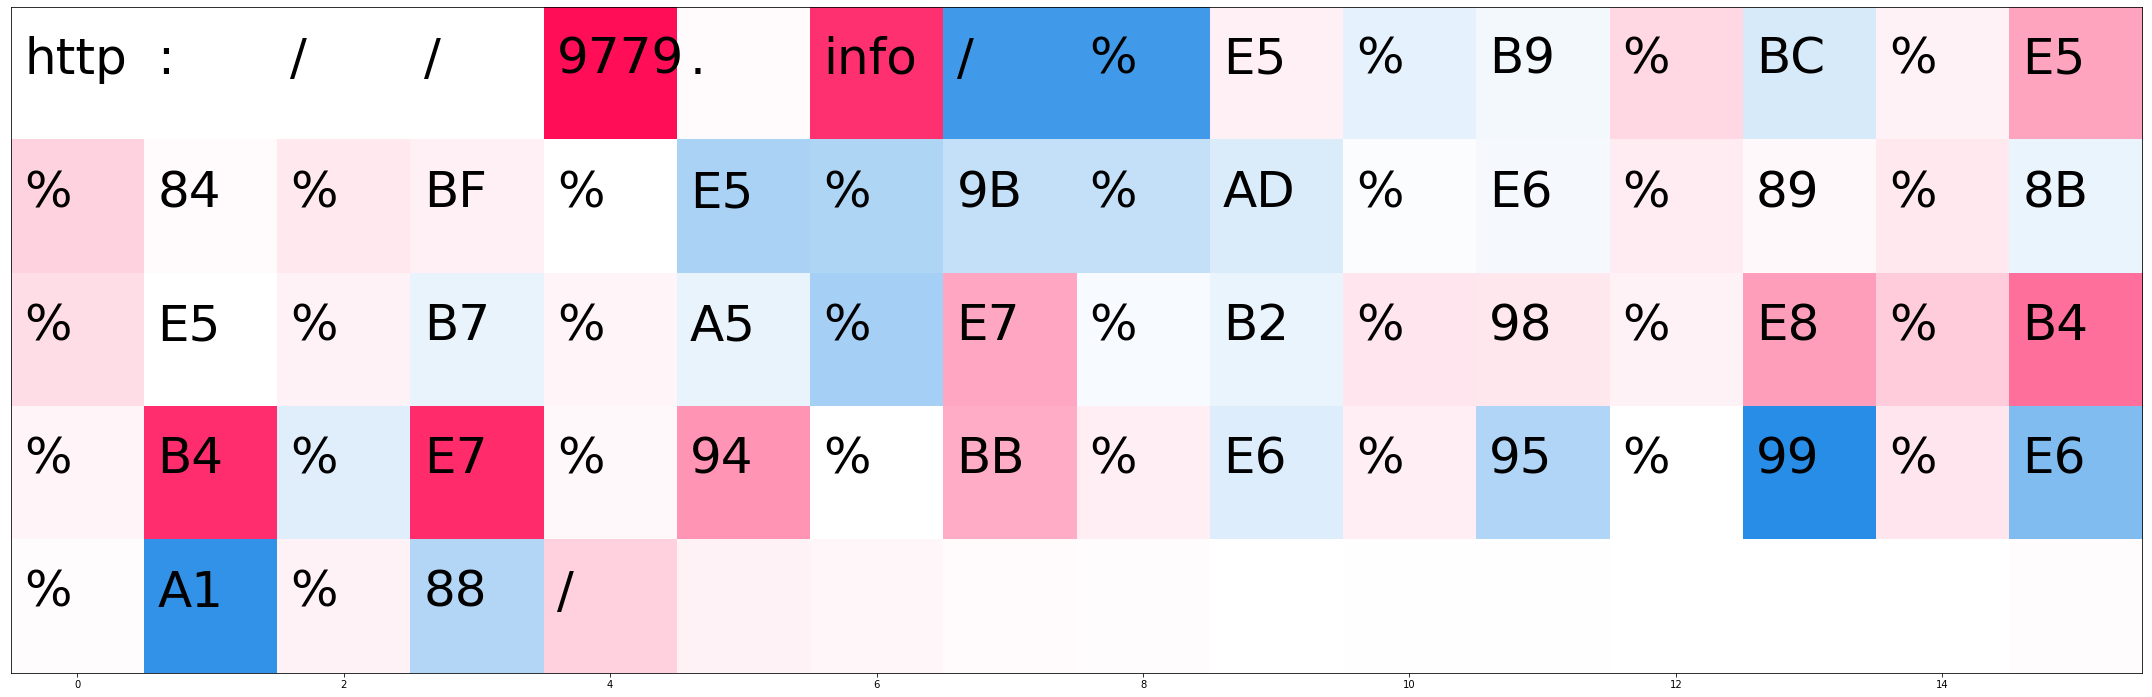

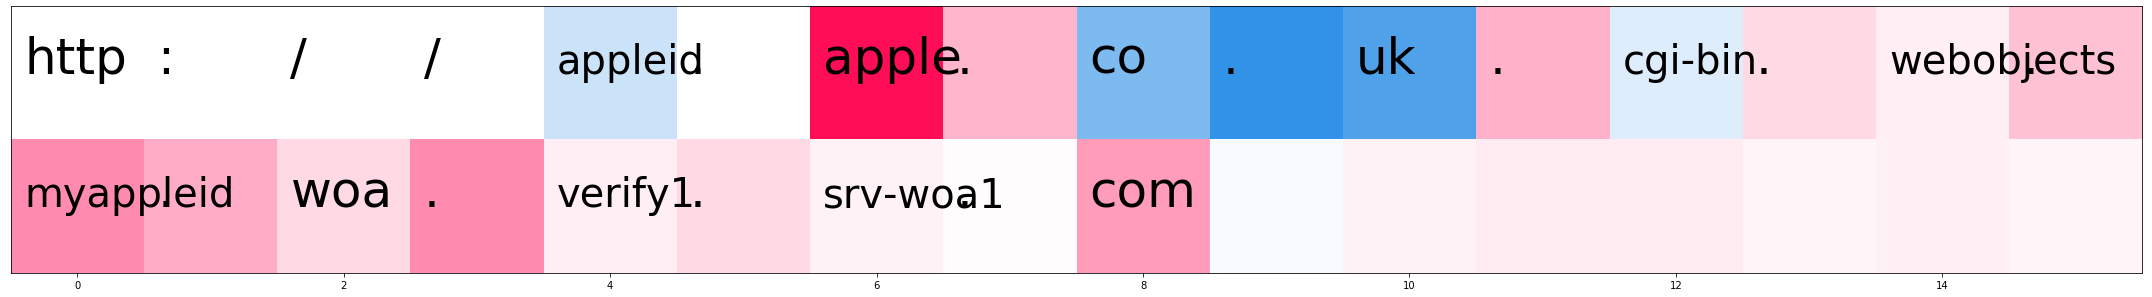

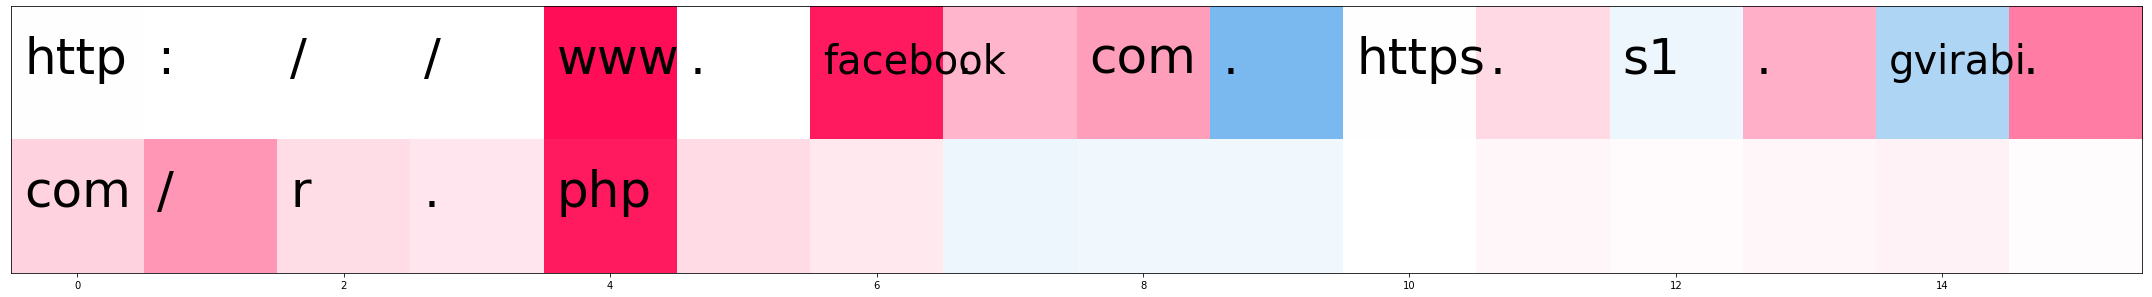

In [320]:
fig1 = plt.figure(figsize=(30, 20), tight_layout=True)
ax = plt.subplot(111)
ax.get_yaxis().set_visible(False)
idx = 207
sample = worded_id_x_train[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight2(sample, shap_values, indexes, -11, (-1, 16), ax)
plt.tight_layout()
plt.savefig('highlight_token1.pdf', bbox_inches = 'tight')

fig2 = plt.figure(figsize=(30, 20), tight_layout=True)
ax = plt.subplot(111)
ax.get_yaxis().set_visible(False)
idx = 2547
sample = worded_id_x_train[idx:idx+1]
#sample = worded_id_x[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight2(sample, shap_values, indexes, -7, (-1, 16), ax)
plt.tight_layout()
plt.savefig('highlight_token2.pdf', bbox_inches = 'tight')

fig3 = plt.figure(figsize=(30, 20), tight_layout=True)
ax = plt.subplot(111)
ax.get_yaxis().set_visible(False)
idx = 15298
sample = worded_id_x_train[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight2(sample, shap_values, indexes, -11, (-1, 16), ax)
plt.tight_layout()
plt.savefig('highlight_token3.pdf', bbox_inches = 'tight')

plt.show()

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


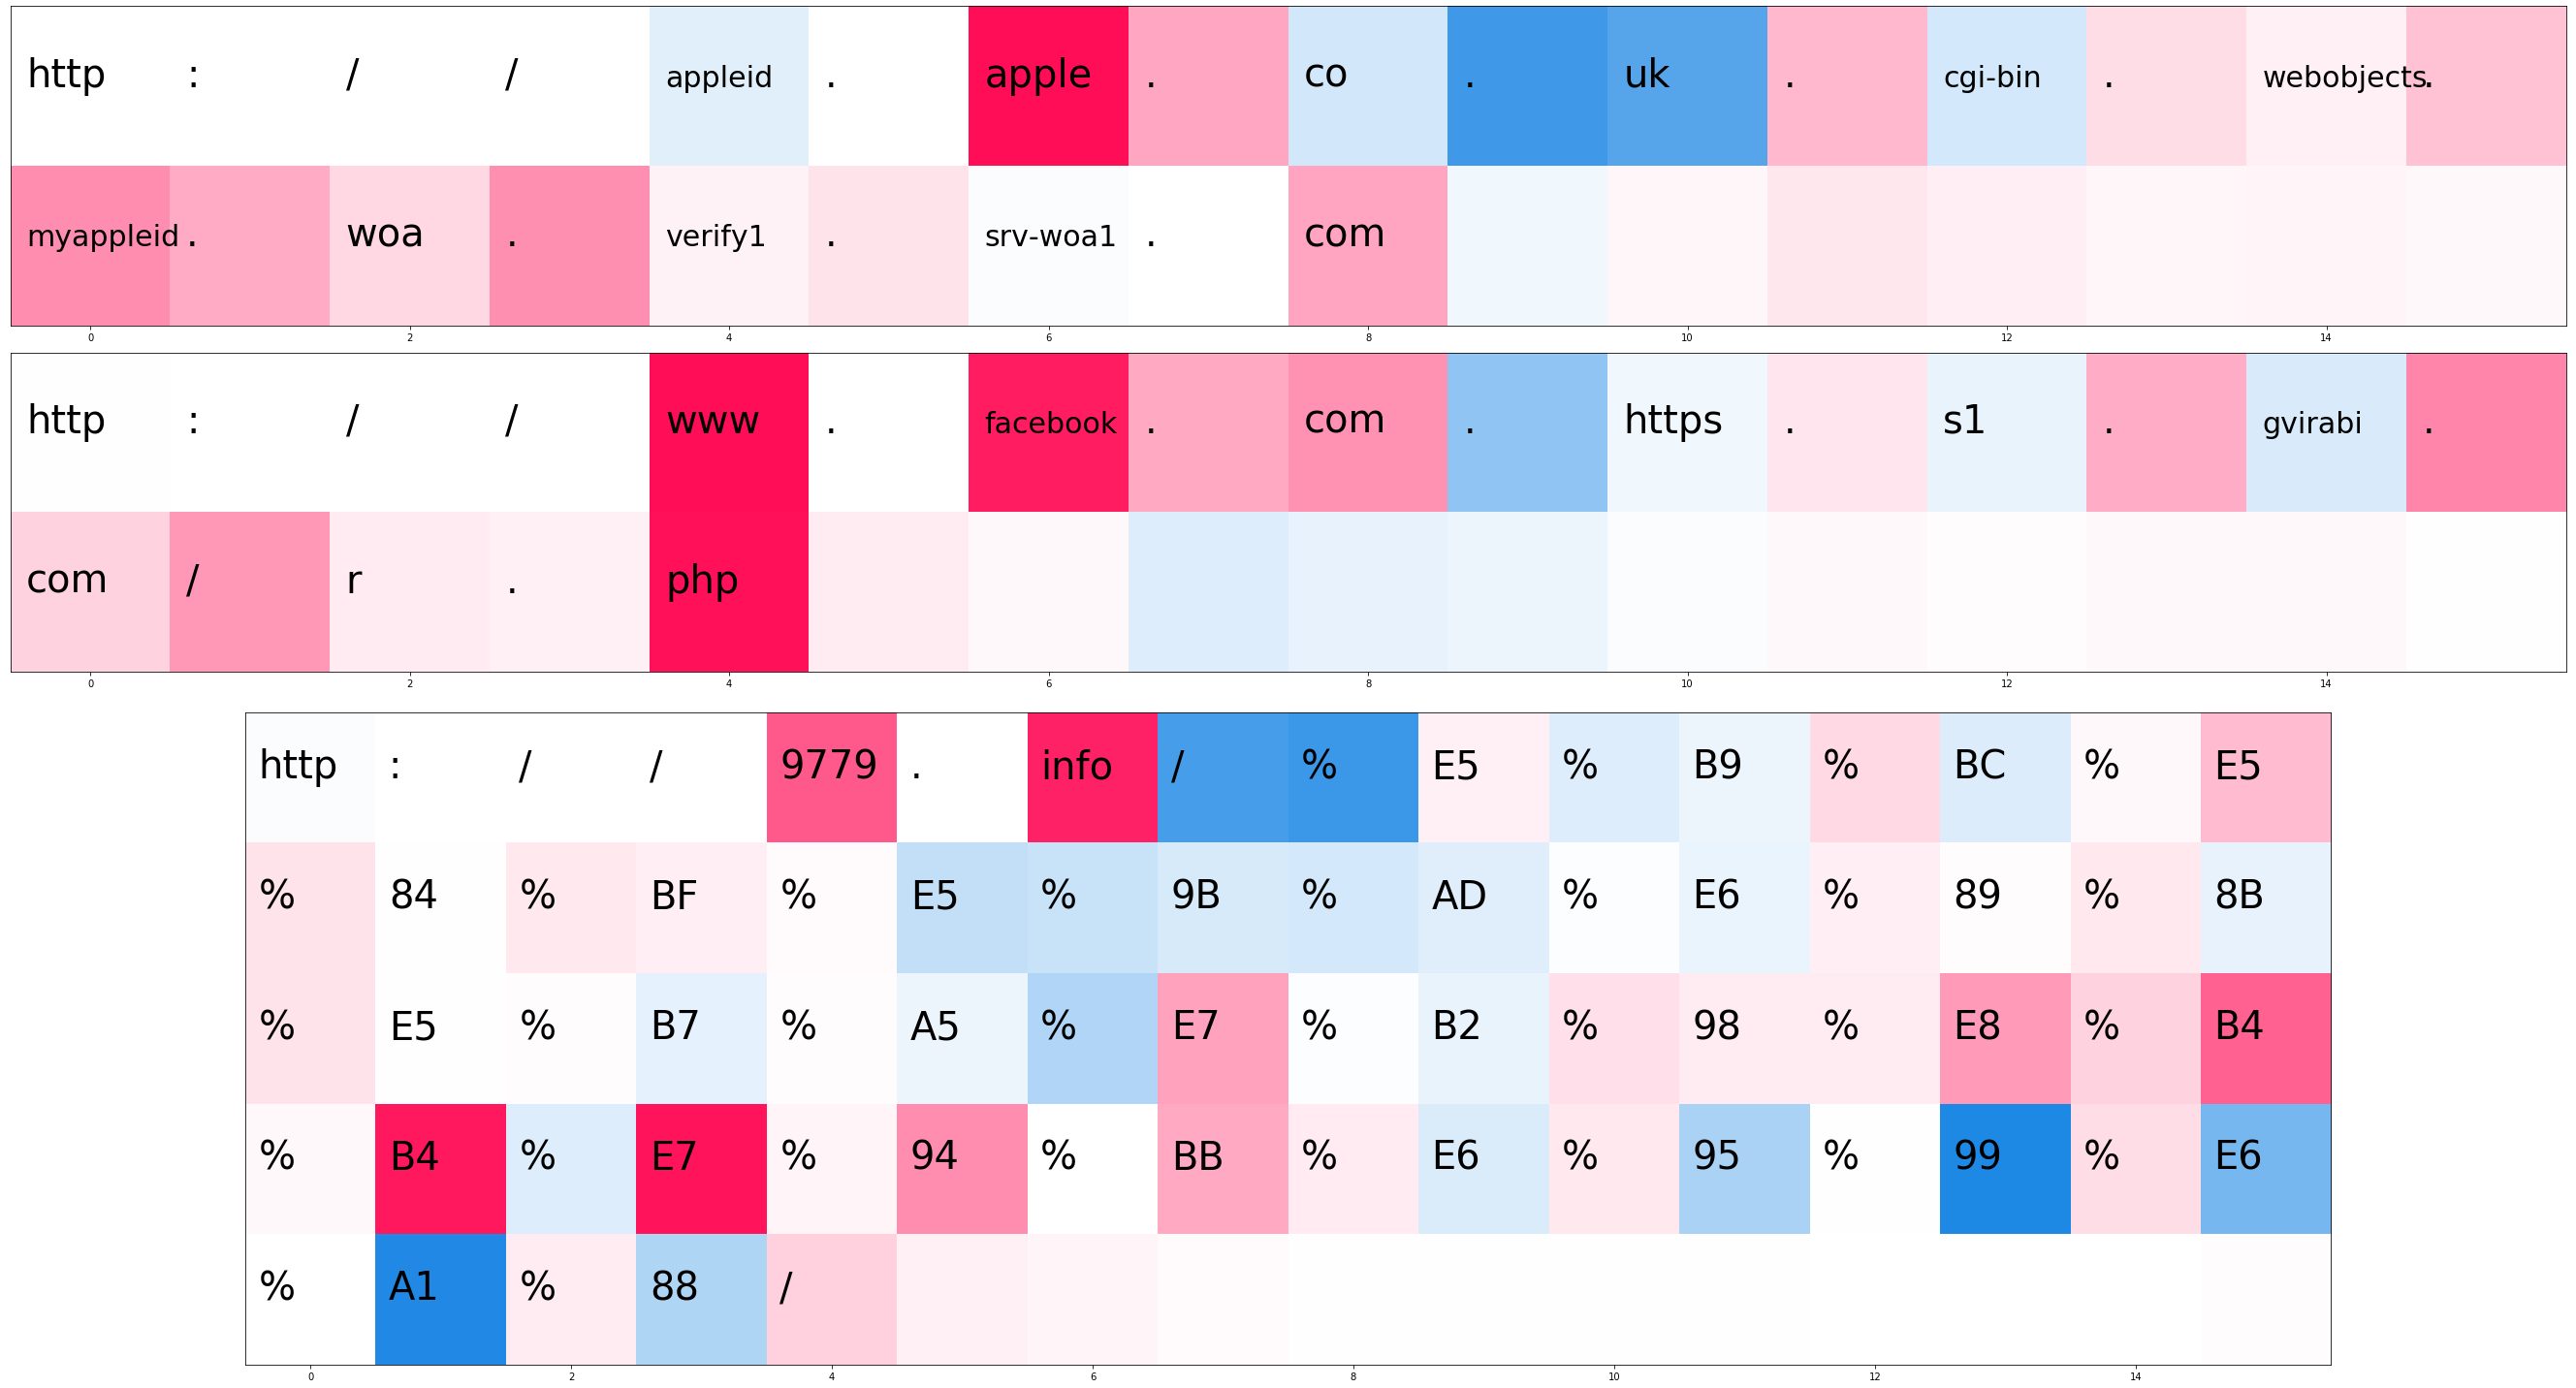

In [318]:
fig1 = plt.figure(figsize=(90, 20), tight_layout=True)
ax = plt.subplot(212)
ax.get_yaxis().set_visible(False)
idx = 207
sample = worded_id_x_train[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight2(sample, shap_values, indexes, -11, (-1, 16), ax)


ax = plt.subplot(411)
ax.get_yaxis().set_visible(False)
idx = 2547
sample = worded_id_x_train[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight2(sample, shap_values, indexes, -7, (-1, 16), ax)


ax = plt.subplot(412)
ax.get_yaxis().set_visible(False)
idx = 15298
sample = worded_id_x_train[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight2(sample, shap_values, indexes, -11, (-1, 16), ax)


plt.tight_layout()
plt.savefig('highlight_token.pdf', bbox_inches = 'tight')
plt.show()

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


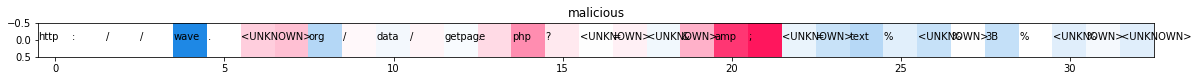

In [63]:
# test one sample
idx = 0
#sample = worded_id_x_train[idx:idx+1]
sample = worded_id_x[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight(sample, shap_values, indexes)

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


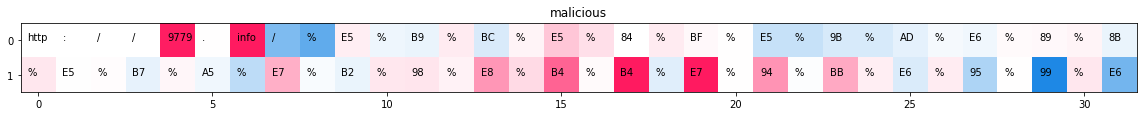

In [131]:
# test one sample
idx = 207
sample = worded_id_x_train[idx:idx+1]
#sample = worded_id_x[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight(sample, shap_values, indexes)

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


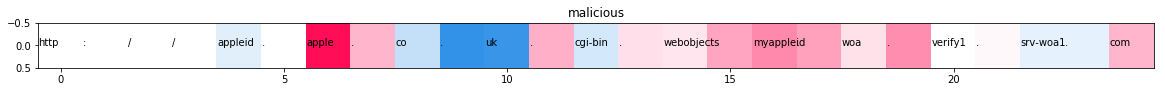

In [74]:
# test one sample
idx = 2547
sample = worded_id_x_train[idx:idx+1]
#sample = worded_id_x[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight(sample, shap_values, indexes)

In [288]:
FindCorrelation('nuevomundo5', 'malicious')

1.0

In [289]:
urls_train[15298]

'http://www.facebook.com.https.s1.gvirabi.com/r.php'

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


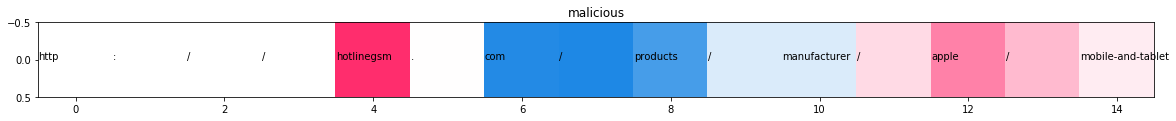

In [73]:
# test one sample
idx = 1778
sample = worded_id_x_train[idx:idx+1]
#sample = worded_id_x[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight(sample, shap_values, indexes)

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


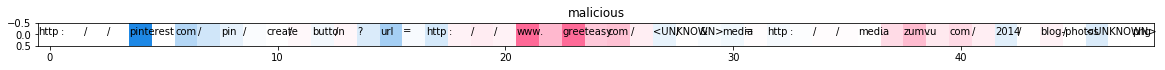

In [46]:
# test one sample
idx = 42
sample = worded_id_x_train[idx:idx+1]
#sample = worded_id_x[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight(sample, shap_values, indexes)

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


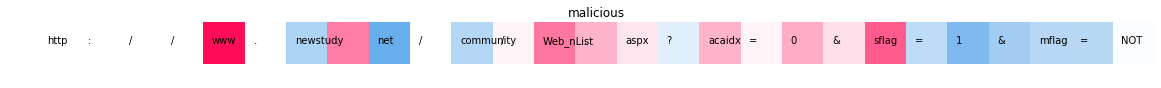

In [243]:
# test one sample
idx = 1387
sample = worded_id_x_train[idx:idx+1]
#sample = worded_id_x[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight(sample, shap_values, indexes)

INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


INFO:tensorflow:Restoring parameters from runs/10000/checkpoints/model-1850


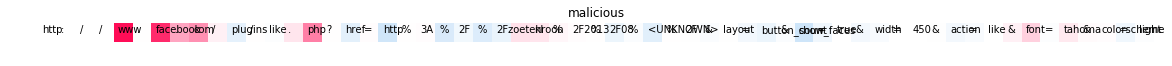

In [246]:
# test one sample
idx = 10
sample = worded_id_x_train[idx:idx+1]
#sample = worded_id_x[idx:idx+1]
e = DADAExplainer(worded_id_x_train)
shap_values, indexes = e.PleaseExplainYourself(sample)
e.ShapStyleURLHighlight(sample, shap_values, indexes)

In [86]:
def FindCorrelation(targettext, targetclass):
    label = {'malicious':0, 'benign':1}[targetclass]
    df_tmp = train_df.copy()
    df_tmp['exist'] = np.array([(targettext in i) for i in word_x_train])
    df = df_tmp.query('exist == True & label == {}'.format(label))
    #print(len(df), df_tmp.exist.sum())
    return len(df) / df_tmp.exist.sum()

In [32]:
# test
test_bias = dict()
class_names = ['malicious', 'benign']
E = DADAExplainer(worded_id_x_train)

for e in tqdm(range(len(worded_id_x))):
    sample = worded_id_x[e:e+1]
    shap_values, indexes = E.PleaseExplainYourself(sample)
    sv = shap_values[0][0].sum(-1)
    sv = sv.reshape(1, -1)
    sv = sv[:,:len(sample[0])]
    critical_idx = np.argmax(sv[0])
    word = reverse_dict[sample[0][critical_idx]]
    corr = FindCorrelation(word, class_names[indexes[0][0]])
    

    if word not in test_bias:
        corr = FindCorrelation(word, class_names[indexes[0][0]])
        test_bias[word] = corr
    #test_bias.append(corr)


INFO:tensorflow:Restoring parameters from runs/10000_inv/checkpoints/model-550


INFO:tensorflow:Restoring parameters from runs/10000_inv/checkpoints/model-550
100%|██████████| 416239/416239 [21:10:25<00:00,  5.46it/s]   


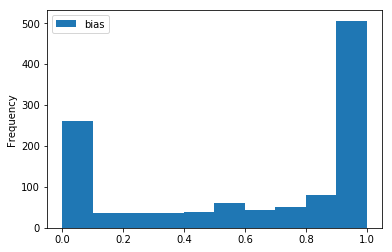

In [38]:
### out.csv
test_bias_df = pd.DataFrame({'bias':list(test_bias.values()), 'word_bias':list(test_bias.keys())})
test_bias_df.plot(kind='hist')
test_bias_df.to_csv('out_bias.csv', index=False)

In [39]:
test_bias_df.head()

,bias,word_bias
0,0.75,first
1,1.00,vs
2,1.00,AS
3,1.00,authentication
4,0.00,country


In [133]:
FindCorrelation('9779', 'malicious')

1.0

#### find the bias of each word tokens
1. catch the most critical word token in explanation and find its ratio in dataset
2. find the bias ratio for each word

In [ ]:
train_bias_df = pd.DataFrame({'train_bias':list(train_bias.values()), 'word_bias':list(word_bias.keys())})
train_bias_df.plot(kind='hist')

In [36]:
train_bias_df.word_bias.values[:10]

array(['.', '.', '.', 'php', '.', '.', 'template', '.', 'bisaneema',
       'bisaneema'], dtype=object)

In [34]:
# test
test_bias = dict()
class_names = ['malicious', 'benign']
E = DADAExplainer(worded_id_x_train)

for e in tqdm(range(len(worded_id_x))):
    sample = worded_id_x[e:e+1]
    shap_values, indexes = E.PleaseExplainYourself(sample)
    sv = shap_values[0][0].sum(-1)
    sv = sv.reshape(1, -1)
    sv = sv[:,:len(sample[0])]
    critical_idx = np.argmax(sv[0])
    word = reverse_dict[sample[0][critical_idx]]
    corr = FindCorrelation(word, class_names[indexes[0][0]])
    

    if word not in test_bias:
        corr = FindCorrelation(word, class_names[indexes[0][0]])
        test_bias[word] = corr
    #test_bias.append(corr)


INFO:tensorflow:Restoring parameters from runs/10000_inv/checkpoints/model-550


INFO:tensorflow:Restoring parameters from runs/10000_inv/checkpoints/model-550
100%|██████████| 5248/5248 [19:14<00:00,  4.54it/s]


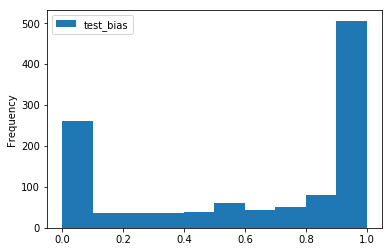

In [35]:
test_bias_df = pd.DataFrame({'test_bias':test_bias})
test_bias_df.plot(kind='hist')

### stored pickle and csv files

#### csv
* train_bias.csv     : bias of most critical word in explanation train set
* test_bias.csv      : bias of most critical word in explanation test set
* char_mal_ratio.csv : ratio of each char
* word_mal_ratio.csv : ratio of each word

#### pickle
* unbias_worded_id_x_train.pkl  : unbias worded_id_x_train
* unbias_worded_id_x.pkl        : unbias worded_id_x
* unbias_chared_id_x_train.pkl  : unbias chared_id_x_train
* unbias_chared_id_x.pkl        : unbias chared_id_x
* char_mal_ratio
* word_mal_ratio

## Detail of each variable

* ngram_dict = chars 2 idx -> dict
* word_dict = word 2 idx -> dict
* char_dict = chars 2 idx -> dict (same as ngram_dict)


1. x, reverse_dict = get_word_vocab(urls, FLAGS["data.max_len_words"])
    Use tflearn.VocabularyProcessor
    x = tokenized and transformed url -> ndarray
    word_reverse_dict -> dict
   
   
2. word_x = get_words(x, word_reverse_dict, FLAGS["data.delimit_mode"], urls)
    word_x = tokenized url -> ndarray
    
3. 
    * train

    ngramed_id_x, ngrams_dict, worded_id_x, words_dict = ngram_id_x(word_x, FLAGS["data.max_len_subwords"], high_freq_words)

    * test
    
    ngramed_id_x_train, worded_id_x_train = ngram_id_x_from_dict(word_x_train, 20, ngram_dict, word_dict) 
    
    
    ngramed_x_id = transformed char-level-word url -> list[list[list]]
    worded_x_id = transformed word url -> list[list]
    
    
4. chared_id_x = char_id_x
    chared_id_x = transformed char url -> list[list]

* word_dict is obtained from ngram_id_x
* x, word_reverse_dict -> only help tokenize